# PREPROCESSING DETECTED DAMAGES FROM A BRIDGE
In this notebook, we read the detected damages from an excell and create geolocated nodes from them.

>This codebase operates on the geomapi code base.

In [1]:
#IMPORT PACKAGES
import os.path
import importlib
import numpy as np
import xml.etree.ElementTree as ET
import open3d as o3d
import uuid    
import pye57 
import ifcopenshell
import ifcopenshell.geom as geom
import ifcopenshell.util
import ifcopenshell.util.selector
import random as rd
import pandas as pd
import cv2
import laspy
import copy
from matplotlib import pyplot as plt
import math
import pathlib

#IMPORT MODULES
from context import geomapi 
from geomapi.nodes import *
import geomapi.utils as ut
from geomapi.utils import geometryutils as gmu
from geomapi.utils import imageutils as iu
import geomapi.tools as tl
from geomapi.tools import progresstools as pt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

# SETUP

In [59]:
## INPUTS
projectPath= os.path.join("K:/Projects/2022-10 Project PhD Erkki/5. Data Fusion")
camerasPath= os.path.join(projectPath,'CamerpositionAfterTransformation.xlsx')
detectionPath=os.path.join(projectPath,'image_data5.xlsx')
meshPath='D:/Data/bridge/Meta_LowMesh_HighTex_geolocated_Cleaned.obj'
imgPath='K:/Projects/2022-10 Project PhD Erkki/4. StandaloneModelsValidationGaardeniersbrug/4. Vegetation'
xmlPath='K:/Projects/2022-10 Project PhD Erkki/4. StandaloneModelsValidationGaardeniersbrug/4. Vegetation/NewCameras.xml '
scale=1/7.6733577080097326e-01 # -> apply to pcd
damageGraphPath='K:/Projects/2022-10 Project PhD Erkki/4. StandaloneModelsValidationGaardeniersbrug/4. Vegetation/damageGraph.ttl '

# IMPORT MESH

In [5]:
meshNode=MeshNode(path=meshPath,getResource=True)

# IMPORT CAMERA INFORMATION

Import camera XML and create imageNodes

In [6]:
imgNodes=tl.img_xml_to_nodes2(xmlPath,filterByFolder=True) 
meshes=[gmu.generate_visual_cone_from_image(n.cartesianTransform, height =0.4) for n in imgNodes]
print(str(len(imgNodes))+ " Nodes created!")

6 Nodes created!


In [7]:
print([n.name for n in imgNodes])

['18_Top_90 (1)', '18_Top_90 (2)', '18_Top_90 (3)', '18_Top_90 (46)', '18_Top_90 (47)', '18_Top_90 (48)']


print values of some random imgNode

In [8]:
{key:value for key, value in imgNodes[0].__dict__.items() if not key.startswith('__') and not callable(key)}              

{'_xmlPath': None,
 '_xmpPath': None,
 '_orientedBoundingBox': None,
 'imageWidth': 4032,
 'imageHeight': 3024,
 'focalLength35mm': 2819.1386798435287,
 'keypoints': None,
 'descriptors': None,
 '_subject': rdflib.term.URIRef('file:///18_Top_90__1_'),
 '_graph': None,
 '_graphPath': None,
 '_path': 'K:/Projects/2022-10 Project PhD Erkki/4. StandaloneModelsValidationGaardeniersbrug/4. Vegetation/18_Top_90 (1).JPG',
 '_name': '18_Top_90 (1)',
 '_timestamp': None,
 '_resource': None,
 '_cartesianTransform': array([[ 7.60852468e-01, -9.93994881e-02,  5.23922159e-03,
          2.85062751e+00],
        [-9.92916024e-02, -7.55083933e-01,  9.37742874e-02,
         -6.10300925e+01],
        [-6.99180767e-03, -9.36599223e-02, -7.61566227e-01,
          1.72937447e+01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]])}

visualize the mesh and the imgNodes

In [9]:
joinedImages=gmu.join_geometries(meshes)
joinedImages=joinedImages.paint_uniform_color([1,0,0])
o3d.visualization.draw_geometries([joinedImages]+[meshNode.resource])

# IMPORT DETECTION INFORMATION

Open excell with damages

In [10]:
df_damage = pd.read_excel(detectionPath,
    header=0,  
    names=['Image Name','Image Directory Path','Damage Name	', 'Count of findings', 'Center x', 'Center y', 'width', 'height', 'Confidence'])
print(df_damage.head)

<bound method NDFrame.head of        Image Name                               Image Directory Path  \
0   18_Top_90 (1)  K:\Projects\2022-10 Project PhD Erkki\4. Stand...   
1   18_Top_90 (1)  K:\Projects\2022-10 Project PhD Erkki\4. Stand...   
2   18_Top_90 (1)  K:\Projects\2022-10 Project PhD Erkki\4. Stand...   
3   18_Top_90 (1)  K:\Projects\2022-10 Project PhD Erkki\4. Stand...   
4   18_Top_90 (2)  K:\Projects\2022-10 Project PhD Erkki\4. Stand...   
5   18_Top_90 (2)  K:\Projects\2022-10 Project PhD Erkki\4. Stand...   
6   18_Top_90 (2)  K:\Projects\2022-10 Project PhD Erkki\4. Stand...   
7   18_Top_90 (3)  K:\Projects\2022-10 Project PhD Erkki\4. Stand...   
8   18_Top_90 (3)  K:\Projects\2022-10 Project PhD Erkki\4. Stand...   
9   18_Top_90 (3)  K:\Projects\2022-10 Project PhD Erkki\4. Stand...   
10  18_Top_90 (3)  K:\Projects\2022-10 Project PhD Erkki\4. Stand...   
11  18_Top_90 (3)  K:\Projects\2022-10 Project PhD Erkki\4. Stand...   
12  18_Top_90 (3)  K:\Projects\202

c:\Users\u0094523\.conda\envs\tf_geomapi2\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


create Nodes of damages and convert damages to point cloud

In [51]:
damageNodes=[]
# rays=np.empty((0,6))
for index, row in df_damage.iterrows():    
    #get appropriete image
    imgName= row['Image Name']
    imgNode=[n for n in imgNodes if n.name == imgName][0]
    
    # if image is found, process the damage
    if imgNode:
        #gather x,y (center) pixel coordinates
        x=math.ceil(row['Center x']*imgNode.imageWidth) # x is column ->
        y=math.ceil(row['Center y']*imgNode.imageHeight) # y is row |
        width=math.ceil(row['width']*imgNode.imageWidth)
        height=math.ceil(row['height']*imgNode.imageWidth)
        
        #compute min and max values
        xmin=math.ceil(x-width/2)
        xmax=math.ceil(x+width/2)
        ymin=math.ceil(y-height/2)
        ymax=math.ceil(y+height/2)
        
        # transform pixel coordinates (first of the center) to rays
        rays=imgNode.create_rays(np.array([[y,x],
                                           [ymin,xmin],
                                           [ymin,xmax],
                                           [ymax,xmin],
                                           [ymax,xmax]
                                           ]))
        # cast rays to 3D mesh (this is inefficient for to many damages)
        distances,ids=gmu.compute_raycasting_collisions(meshNode.resource,rays)
        #compute endpoints 
        _,endpoints=gmu.rays_to_points(rays,distances)

        # create damage nodes
        damageNodes.append(ImageNode(resource=imgNode.resource[ymin:ymax,xmin:xmax],
                                     damageName=row['Damage Name	'],
                                     ray=rays,
                                     distances=distances,
                                     endpoints=endpoints,
                                     roi=(xmin,xmax, ymin, ymax),
                                     confidence=row['Confidence']))
print(str(len(damageNodes))+ " Nodes created!")

[[  4.72175242 -63.26418274   4.95457346]
 [  4.51408506 -61.30620691   4.78972918]
 [  5.53041631 -61.43794103   4.9702789 ]
 [  3.94152685 -65.0363419    4.9250922 ]
 [  4.91789262 -65.10737458   5.09646241]]
[[ inf  inf -inf]
 [ inf  inf -inf]
 [ inf  inf -inf]
 [ inf  inf -inf]
 [ inf  inf -inf]]
[[ inf  inf -inf]
 [ inf  inf -inf]
 [ inf  inf -inf]
 [ inf  inf -inf]
 [ inf  inf -inf]]
[[ inf  inf -inf]
 [ inf  inf -inf]
 [ inf  inf -inf]
 [ inf  inf -inf]
 [ inf -inf -inf]]
[[ inf  inf -inf]
 [ inf  inf -inf]
 [ inf  inf -inf]
 [ inf  inf -inf]
 [ inf  inf -inf]]
[[  4.70504159 -63.27422863   4.9526915 ]
 [  4.48753973 -61.34546015   4.78999838]
 [  5.51121759 -61.47437624   4.96989692]
 [  3.92682043 -65.01732013   4.92513912]
 [  4.91080814 -65.08719536   5.09444474]]
[[ inf  inf -inf]
 [ inf  inf -inf]
 [ inf  inf -inf]
 [ inf -inf -inf]
 [ inf -inf -inf]]
[[ inf  inf -inf]
 [ inf  inf -inf]
 [ inf  inf -inf]
 [ inf  inf -inf]
 [ inf  inf -inf]]
[[ inf  inf -inf]
 [ inf  inf -i

In [39]:
{key:value for key, value in damageNodes[0].__dict__.items() if not key.startswith('__') and not callable(key)}              

{'_xmlPath': None,
 '_xmpPath': None,
 '_orientedBoundingBox': None,
 'imageWidth': 240,
 'imageHeight': 899,
 'focalLength35mm': None,
 'keypoints': None,
 'descriptors': None,
 '_subject': rdflib.term.URIRef('file:///c4e94d32-be6a-11ed-baa3-c8f75043ce59'),
 '_graph': None,
 '_graphPath': None,
 '_path': None,
 '_name': 'c4e94d32-be6a-11ed-baa3-c8f75043ce59',
 '_timestamp': None,
 '_resource': array([[[152, 147, 148],
         [144, 139, 140],
         [141, 136, 137],
         ...,
         [141, 136, 137],
         [143, 138, 139],
         [147, 142, 143]],
 
        [[160, 155, 156],
         [158, 153, 154],
         [153, 148, 149],
         ...,
         [146, 141, 142],
         [145, 140, 141],
         [148, 143, 144]],
 
        [[157, 152, 153],
         [157, 152, 153],
         [159, 154, 155],
         ...,
         [148, 143, 144],
         [145, 140, 141],
         [146, 141, 142]],
 
        ...,
 
        [[148, 146, 146],
         [149, 147, 147],
         [146, 14

In [53]:
damageNodes[0].ray

array([[ 2.85062751e+00, -6.10300925e+01,  1.72937447e+01,
         1.47581114e-01, -1.76209257e-01, -9.73226650e-01],
       [ 2.85062751e+00, -6.10300925e+01,  1.72937447e+01,
         1.31840468e-01, -2.18839716e-02, -9.91029355e-01],
       [ 2.85062751e+00, -6.10300925e+01,  1.72937447e+01,
         2.12377258e-01, -3.23226071e-02, -9.76653034e-01],
       [ 2.85062751e+00, -6.10300925e+01,  1.72937447e+01,
         8.36131751e-02, -3.07063379e-01, -9.48008923e-01],
       [ 2.85062751e+00, -6.10300925e+01,  1.72937447e+01,
         1.58705404e-01, -3.13015830e-01, -9.36393980e-01]])

visualize the rays

In [58]:
array=np.vstack([n.ray for n in damageNodes])
darray=np.vstack([np.reshape(n.distances,(distances.shape[0],1)) for n in damageNodes])
line_set=gmu.rays_to_lineset(array,darray)
# # line_set.colors=o3d.utility.Vector3dVector(np.vstack((np.array([1,0,0]),np.array([0,1,0]),np.array([0,0,1]),np.zeros((len(line_set.lines)-3,3)))))
o3d.visualization.draw_geometries([line_set]+[meshNode.resource]+[joinedImages])

(65, 6)
[[12.67862 ]
 [12.6172  ]
 [12.618059]
 [13.046979]
 [13.025802]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [12.699111]
 [12.603284]
 [12.599256]
 [13.092107]
 [13.066835]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [12.855373]
 [12.610262]
 [12.599731]
 [13.394952]
 [13.352812]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [16.36185 ]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]
 [      inf]]



export damgnodes to graph

In [62]:
# delete unncessery info
for n in damageNodes:
    del n.ray
    del n.distances

In [63]:
damageGraph=tl.nodes_to_graph(damageNodes,damageGraphPath,save=True)
print (str(len(damageNodes))+' Nodes succesfully serialized in: '+damageGraphPath)

13 Nodes succesfully serialized in: K:/Projects/2022-10 Project PhD Erkki/4. StandaloneModelsValidationGaardeniersbrug/4. Vegetation/damageGraph.ttl 


show the image and the damage

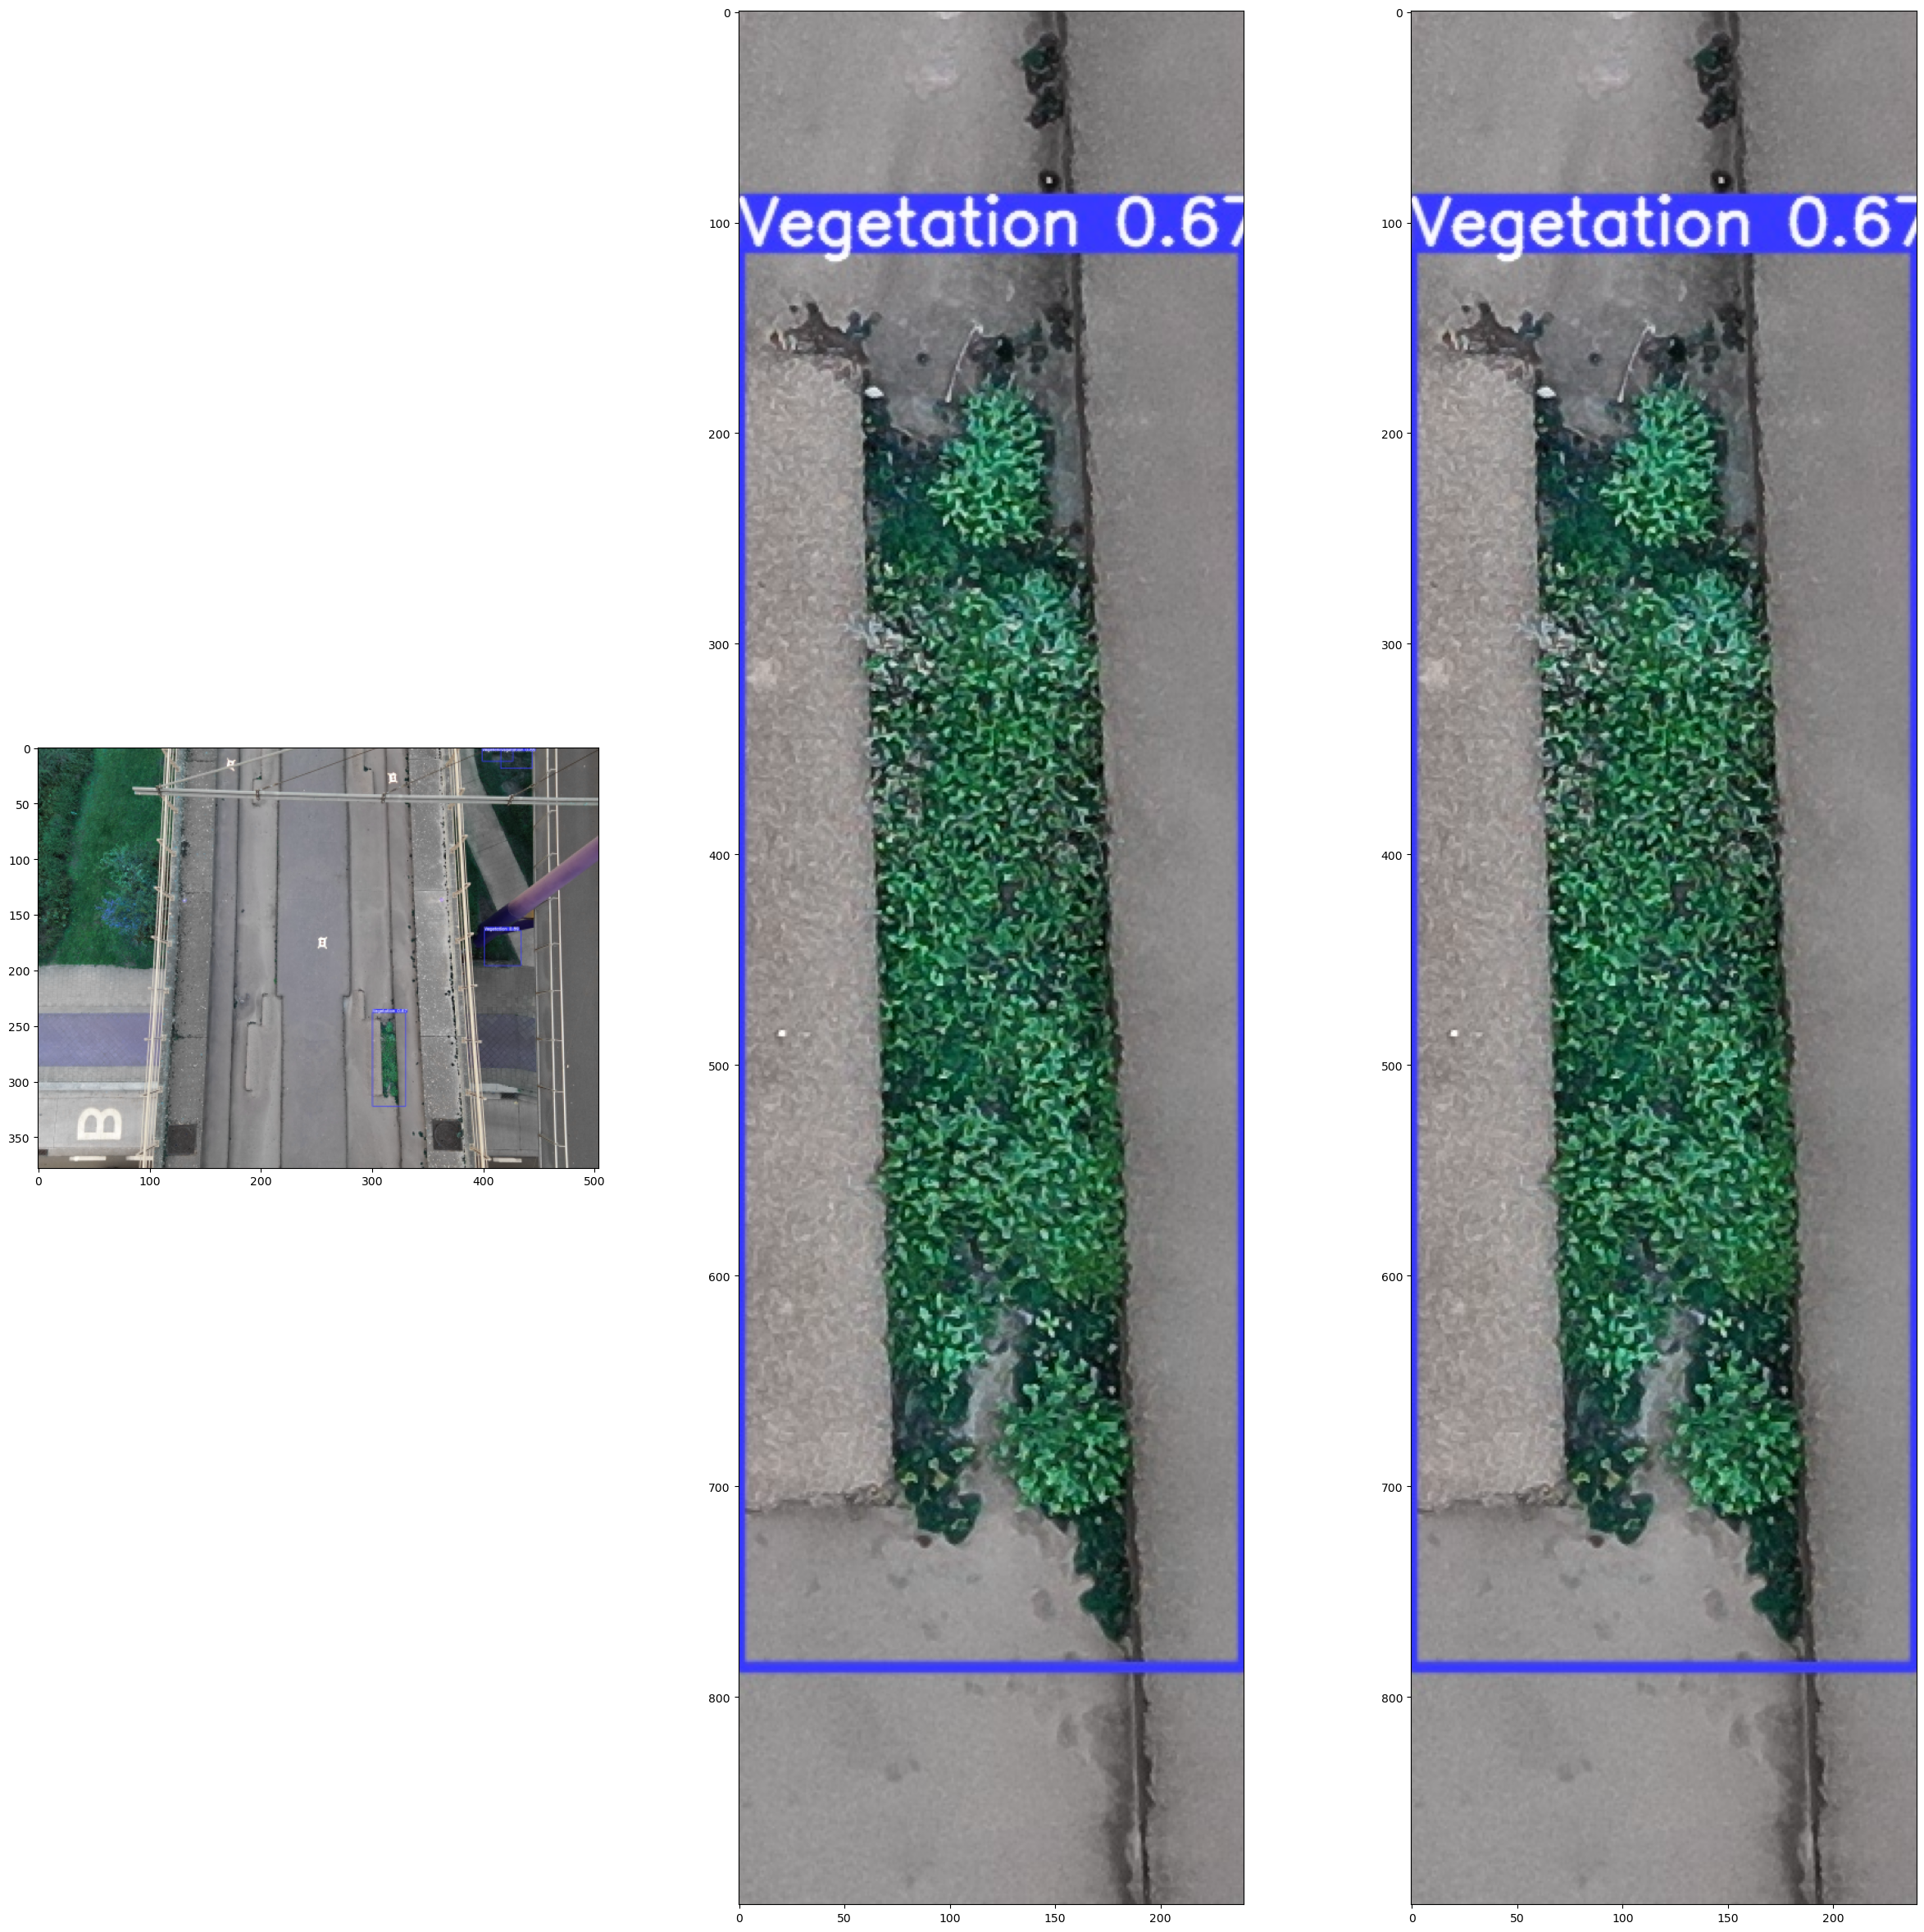

In [ ]:
from matplotlib import pyplot as plt
import math
n=imgNodes[0]
t=damageNodes[0]
fig, axs = plt.subplots(1, 3,figsize=(30, 30))
fig.set_facecolor("white")
axs[0].imshow(iu.image_resize(n.resource,scale=1/8))
axs[1].imshow(iu.image_resize(t.resource,scale=1))
axs[2].imshow(iu.image_resize(t.resource,scale=1))
plt.show()

# ALTENATIVELY, COMPUTE ALL RAYS AT THE SAME TIME

cast rays to the mesh

In [18]:
distances,ids=gmu.compute_raycasting_collisions(meshNode.resource,rays)

[12.67862  12.6172   12.618059 13.046979 13.025802       inf       inf
       inf       inf       inf       inf       inf       inf       inf
       inf       inf       inf       inf       inf       inf       inf
       inf       inf       inf       inf 12.699111 12.603284 12.599256
 13.092107 13.066835       inf       inf       inf       inf       inf
       inf       inf       inf       inf       inf       inf       inf
       inf       inf       inf 12.855373 12.610262 12.599731 13.394952
 13.352812       inf       inf       inf       inf       inf       inf
 16.36185        inf       inf       inf       inf       inf       inf
       inf       inf] [         0          0          0          0          0 4294967295
 4294967295 4294967295 4294967295 4294967295 4294967295 4294967295
 4294967295 4294967295 4294967295 4294967295 4294967295 4294967295
 4294967295 4294967295 4294967295 4294967295 4294967295 4294967295
 4294967295          0          0          0          0          0
 429

use distances to compute 3D coordinate of each damage and assign it to the damage nodes.

In [23]:
_,endpoints=gmu.rays_to_points(rays,distances)

[[  4.721752  -63.264183    4.9545736]
 [  4.514085  -61.30621     4.789729 ]
 [  5.5304165 -61.437943    4.9702787]
 [  3.941527  -65.03635     4.9250927]
 [  4.9178925 -65.107376    5.096463 ]
 [        inf         inf        -inf]
 [        inf         inf        -inf]
 [        inf         inf        -inf]
 [        inf         inf        -inf]
 [        inf         inf        -inf]
 [        inf         inf        -inf]
 [        inf         inf        -inf]
 [        inf         inf        -inf]
 [        inf         inf        -inf]
 [        inf         inf        -inf]
 [        inf         inf        -inf]
 [        inf         inf        -inf]
 [        inf         inf        -inf]
 [        inf         inf        -inf]
 [        inf        -inf        -inf]
 [        inf         inf        -inf]
 [        inf         inf        -inf]
 [        inf         inf        -inf]
 [        inf         inf        -inf]
 [        inf         inf        -inf]
 [  4.705042  -63.27423  

visualize the new rays

In [33]:
# array=np.hstack((rays.numpy()[:,:3],endpoints))
# rays = o3d.core.Tensor(array,dtype=o3d.core.Dtype.Float32)  
line_set=gmu.rays_to_lineset(rays,distances)
# line_set.colors=o3d.utility.Vector3dVector(np.vstack((np.array([1,0,0]),np.array([0,1,0]),np.array([0,0,1]),np.zeros((len(line_set.lines)-3,3)))))
o3d.visualization.draw_geometries([line_set]+[meshNode.resource]+[joinedImages])